# Stage 5 

<img src='https://drive.google.com/uc?export=download&id=1lLvyacJgfzQINpyIoRT0kzLW8Bw4bsJO' width="" height ="" /><br>

# Intro

   우리는 지난 시간에 여러가지 분류모델을 배우고 모델에 따른 성능을 비교해보았습니다. 
   
이제 다시 **전처리 단계**로 돌아가 <font color=coral>**새로운 feature를 생성해 성능을 높이는 방법**</font>을 알아보도록 하겠습니다. 

**전처리되기 전 원래 train ,test 데이터**를 불러와볼까요? 

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

우리에게 train 19개, test 18개의 열이 기존에 주어져 있었습니다. 먼저 각 열들이 의미하는 바를 살펴봅시다. 
> - gender : 성별   
> - car : 차량소유여부   
> - reality: 부동산 소유 여부   
> - child_num : 자녀 수   
> - income_total: 연간 소득   
> - income_type: 소득 분류   
> - edu_type: 교육 수준   
> - family_type: 결혼 여부   
> - house_type: 생활 방식   
> - DAYS_BIRTH: 출생일   
> - DAYS_EMPLOYED: 업무 시작일   
> - FLAG_MOBIL: 핸드폰 소유 여부   
> - work_phone : 업무용 전화 소유 여부   
> - phone: 전화 소유 여부   
> - email: 이메일 소유 여부   
> - occyp_type: 직업 유형   
> - family_size: 가족 규모   
> - begin_month: 신용카드 발급 월   
> - credit: 신용도 (낮을수록 높은 신용) -> 정답값 

우리는 이제 앞에서 배운 EDA를 통해 정답값과 다른 열들사이의 관계를 살펴보고 이를 바탕으로 새로운 열을 도출해내는 방법을 배워볼 예정입니다.   

이때, <font color=croal>주의해야 할 점은 결국 우리는 test 데이터로 예측값을 내보내야 하므로 새로운 열을 생성할 때, **train 과 test 모두에 동일하게 생성해야한다는 점입니다!**</font>    

그럼 바로 시작해볼까요? 😁

In [3]:
# 새롭게 생성한 열을 담을 dataframe 
dt_train = pd.DataFrame()
dt_test = pd.DataFrame()

---

본격적으로 들어가기 전에 우선 **신용등급(credit) 즉, train 데이터의 정답값의 비율**을 먼저 그래프로 살펴볼까요? 

In [4]:
# 시각화에서 가장 많이 쓰는 두가지 패키지
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# matplotlib 한글 폰트 출력코드
import matplotlib
from matplotlib import font_manager, rc
import platform

try : 
    if platform.system() == 'Windows':
    # 윈도우인 경우
        font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        rc('font', family=font_name)
    else:    
    # Mac 인 경우
        rc('font', family='AppleGothic')
except : 
    pass
matplotlib.rcParams['axes.unicode_minus'] = False

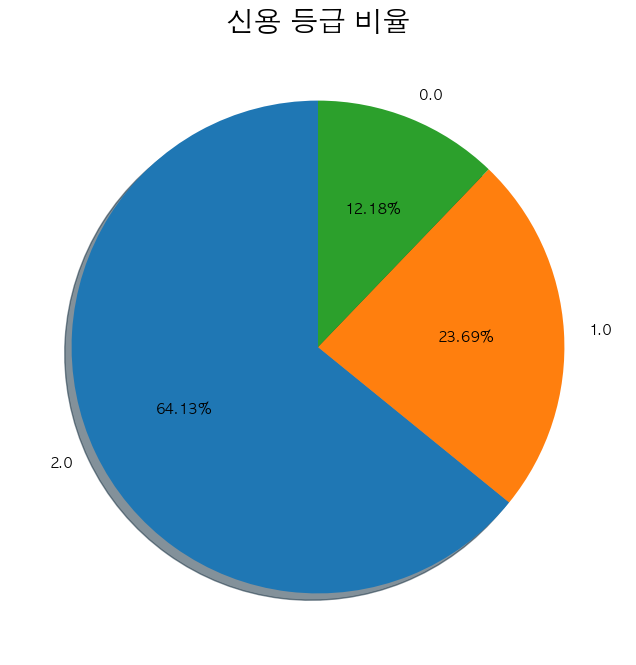

In [6]:
plt.subplots(figsize = (8,8))
plt.pie(train['credit'].value_counts(), labels = train['credit'].value_counts().index, 
        autopct="%.2f%%", shadow = True, startangle = 90)
plt.title('신용 등급 비율', size=20)
plt.show()

credit 열은 낮을수록 높은 신용의 신용카드 사용자를 뜻합니다. 연체할 가능성이 낮다는 이야기겠죠?   
따라서, 위의 그래프로 **낮은 신용의 사용자가 대부분을 차지하고 있음**을 알 수 있습니다.   

이제 정답값의 등급에 따른 차이를 보기 위해 데이터를 분류해 놓고 본격적으로 시작해보겠습니다.

In [7]:
# 등급에 따른 차이를 보기 위한 데이터 분류
train_0 = train[train['credit']==0.0]
train_1 = train[train['credit']==1.0]
train_2 = train[train['credit']==2.0]

# 1. EDA 를 통한 새로운 변수 생성  


범주형 변수와 수치형 변수의 여부에 따라 그래프 생성의 코드가 조금씩 달라지니 그래프 함수를 미리 정의하고 시작하겠습니다.   

코드를 찬찬히 살펴보시면 stage3에서 배운 EDA 코드들이 눈에 보일겁니다. 😊  

배우지 않은 코드들은 구글링을 통해 알아보면 좋을 것 같아요! 😉

In [8]:
# Categorical 그래프 함수 정의
def cat_plot(column):

  f, ax = plt.subplots(1, 3, figsize=(16, 6))


  sns.countplot(x = column,
                data = train_0,
                ax = ax[0],
                order = train_0[column].value_counts().index)
  ax[0].tick_params(labelsize=12)
  ax[0].set_title('credit = 0')
  ax[0].set_ylabel('count')
  ax[0].tick_params(rotation=50)


  sns.countplot(x = column,
                data = train_1,
                ax = ax[1],
                order = train_1[column].value_counts().index)
  ax[1].tick_params(labelsize=12)
  ax[1].set_title('credit = 1')
  ax[1].set_ylabel('count')
  ax[1].tick_params(rotation=50)

  sns.countplot(x = column,
                data = train_2,
                ax = ax[2],
                order = train_2[column].value_counts().index)
  ax[2].tick_params(labelsize=12)
  ax[2].set_title('credit = 2')
  ax[2].set_ylabel('count')
  ax[2].tick_params(rotation=50)
  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  plt.show()


In [9]:
# Numerical 그래프 함수 정의
def num_plot(column):
  
  fig, axes = plt.subplots(1, 3, figsize=(16, 6))


  sns.distplot(train_0[column],
                ax = axes[0])
  axes[0].tick_params(labelsize=12)
  axes[0].set_title('credit = 0')
  axes[0].set_ylabel('count')

  sns.distplot(train_1[column],
                ax = axes[1])
  axes[1].tick_params(labelsize=12)
  axes[1].set_title('credit = 1')
  axes[1].set_ylabel('count')

  sns.distplot(train_2[column],
                ax = axes[2])
  axes[2].tick_params(labelsize=12)
  axes[2].set_title('credit = 2')
  axes[2].set_ylabel('count')
  plt.subplots_adjust(wspace=0.3, hspace=0.3)

## 1.1 신용등급 별 소득분류(income type)의 차이가 존재할까?

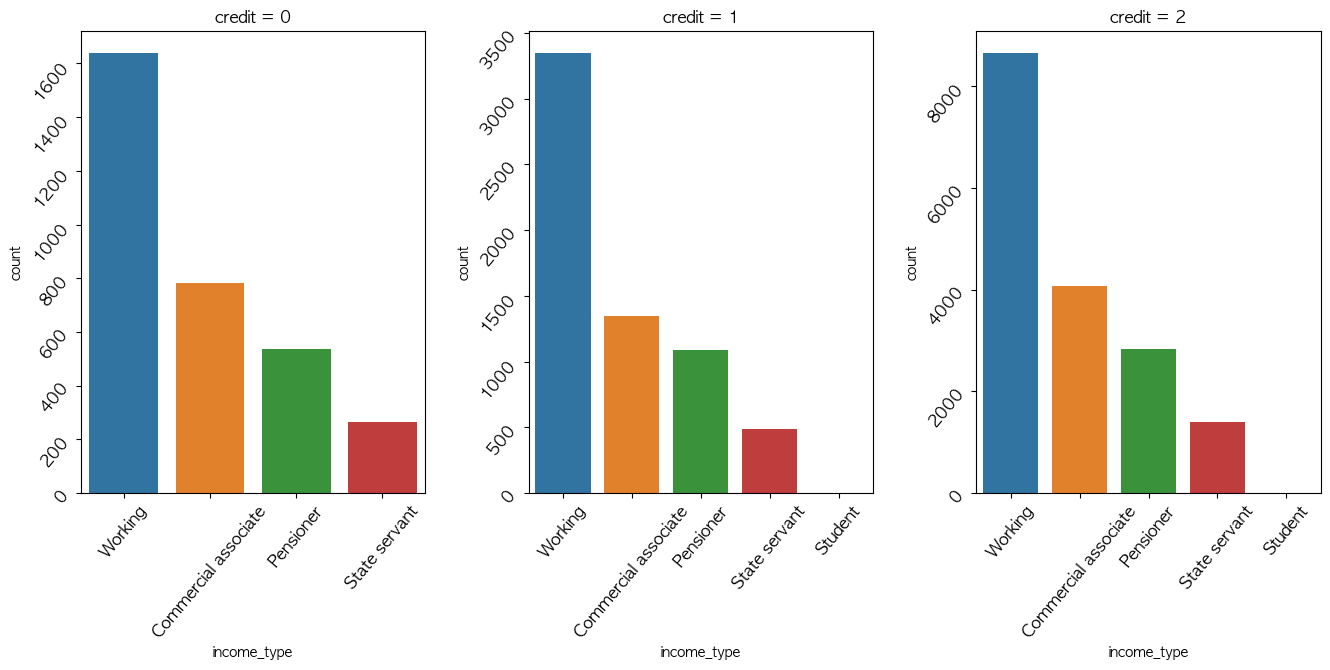

In [10]:
cat_plot('income_type')

가장 눈에 띄는 특징은 <font color=coral>**높은 신용에서는 학생이 존재하지 않는다는 점입니다.**</font>  
학생의 신분 특성상 높은 신용을 가지기 어려운 현실적인 상황이 반영되어 있는 것을 알 수 있습니다.  

이를 통해 우리가 유추할 수 있는 점은 어떤 소득의 종류를 가지고 있느냐가 신용등급의 영향을 주고 있다는 것입니다.  
학생의 경우 취업이 되지 않았다는 것을 의미합니다.   
이를 DAYS_EMPLOYED 열을 사용해 새로운 열 **'emp'** 를 만들어보겠습니다. 

In [11]:
# 취업 여부 'emp'
dt_train['emp'] = train['DAYS_EMPLOYED'] > 0 
dt_test['emp'] = test['DAYS_EMPLOYED'] > 0 

# 전처리 
dt_train['emp'] = dt_train['emp'].replace([True,False],[0,1])
dt_test['emp'] = dt_test['emp'].replace([True,False],[0,1])

display(dt_train)

,emp
0,1
1,1
2,1
3,1
4,1
...,...
26452,1
26453,1
26454,1
26455,1


### Inst. 
- 위의 시각화를 통해 일을 하는 시점 역시 중요함을 알 수 있습니다.   
- 일을 하게된 시점을 'BIRTH_MINUS_EMPLOYED'라는 새로운 변수로 만들어보세요. 

In [12]:
# 일을 하게된 시점 변수 생성 




### Hint. 
- 'DAYS_BIRTH', 'DAYS_EMPLOYED'열을 이용하세요. 

### Solution.

In [13]:
dt_train['BIRTH_MINUS_EMPLOYED'] = train['DAYS_BIRTH'] - train['DAYS_EMPLOYED']
dt_test['BIRTH_MINUS_EMPLOYED'] = test['DAYS_BIRTH'] - test['DAYS_EMPLOYED']

display(dt_train)
display(dt_test)

,emp,BIRTH_MINUS_EMPLOYED
0,1,-9190
1,1,-9840
2,1,-14653
3,1,-12996
4,1,-12932
...,...,...
26452,1,-10095
26453,1,-12816
26454,1,-8067
26455,1,-10038


,emp,BIRTH_MINUS_EMPLOYED
0,0,-387233
1,1,-10293
2,1,-15670
3,1,-16739
4,1,-8437
...,...,...
9995,1,-13159
9996,1,-9571
9997,1,-6998
9998,1,-15456


## 1.2 신용 등급에 따라 결혼 여부 차이가 존재할까?

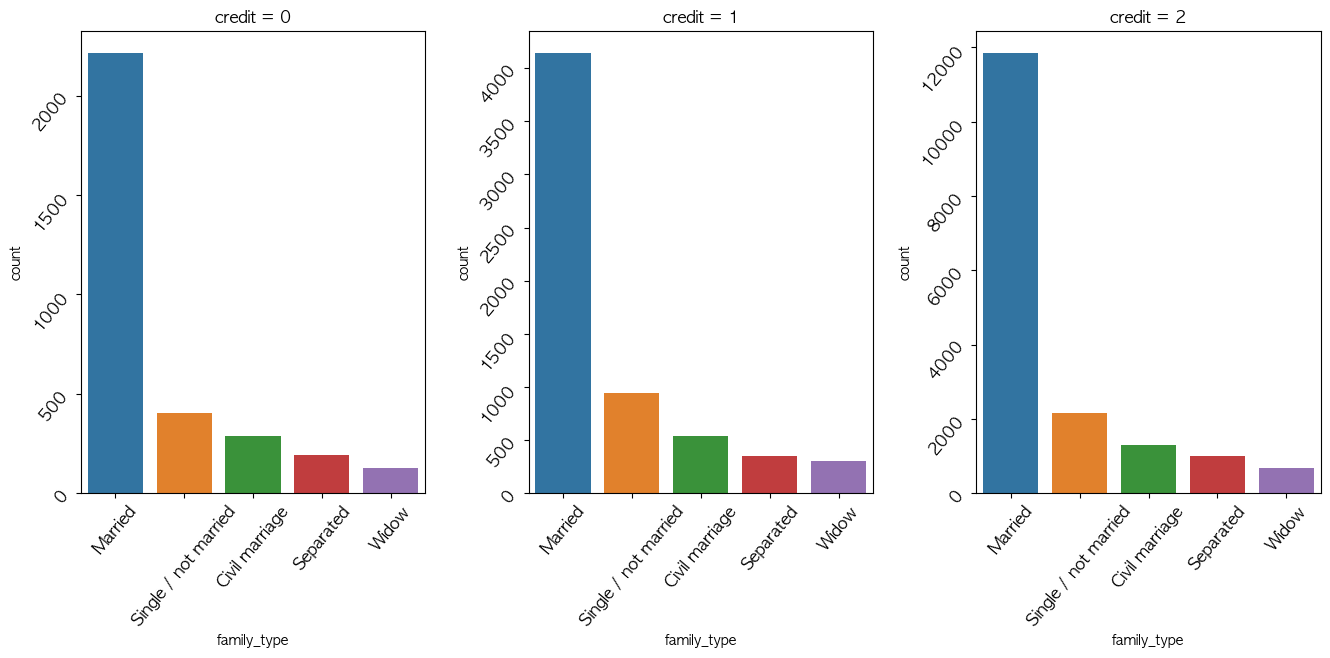

In [14]:
cat_plot('family_type')

모든 신용등급에서 결혼을 한 사람들이 가장 많음을 알 수 있습니다.   
즉, **결혼을 한 사람들이 상대적으로 많이 존재한다는 것을 의미하겠죠?**  

그렇다면, 가정의 어른의 수, 수입의 비율등이 중요하게 작용할 수 있다고 생각할 수 있습니다.   
먼저, 가족내의 어른의 수를 **'diff_fam_child'** 라는 새로운 열로 만들어 볼까요? 

In [15]:
# 어른의 숫자 
dt_train['diff_fam_child'] = train['family_size'] - train['child_num']
dt_test['diff_fam_child'] = test['family_size'] - test['child_num']

display(dt_train)

,emp,BIRTH_MINUS_EMPLOYED,diff_fam_child
0,1,-9190,2.0
1,1,-9840,2.0
2,1,-14653,2.0
3,1,-12996,2.0
4,1,-12932,2.0
...,...,...,...
26452,1,-10095,2.0
26453,1,-12816,1.0
26454,1,-8067,2.0
26455,1,-10038,1.0


수입을 가족의 수로 나눈 비율도 신용등급에 영향을 줄 수 있습니다. 

In [16]:
# income을 가족 수로 나눈 비율 
dt_train['INCOME_FAM_RATIO'] = train['income_total']/train['family_size']
dt_test['INCOME_FAM_RATIO'] = test['income_total']/test['family_size']

display(dt_train)

,emp,BIRTH_MINUS_EMPLOYED,diff_fam_child,INCOME_FAM_RATIO
0,1,-9190,2.0,101250.0
1,1,-9840,2.0,82500.0
2,1,-14653,2.0,225000.0
3,1,-12996,2.0,101250.0
4,1,-12932,2.0,78750.0
...,...,...,...,...
26452,1,-10095,2.0,56250.0
26453,1,-12816,1.0,90000.0
26454,1,-8067,2.0,146250.0
26455,1,-10038,1.0,171000.0


### Inst. 
- 결혼을 한 사람이 많다면 자식의 숫자에 따라 신용등급에 영향을 받을 수도 있습니다.   
- 수입을 자식의 수로 나눈 비율을 'INCOME_child_num_RATIO'의 새로운 열로 만들어보세요. 
- 자식이 없을 수도 있습니다. 'inf'로 나오는 행을 전처리 해보세요.

In [17]:
# income을 자식 수로 나눈 비율 



# 전처리 




### Hint. 
- 'income_total'열과 'child_num'열을 사용하세요.
- 전처리는 replace를 사용하면 간단합니다. 😊

### Solution. 

In [18]:
# income을 자식 수로 나눈 비율 
dt_train['INCOME_child_num_RATIO'] = train['income_total']/train['child_num']
dt_test['INCOME_child_num_RATIO'] = test['income_total']/test['child_num']

# 전처리 
import numpy as np 
dt_train['INCOME_child_num_RATIO'] = dt_train['INCOME_child_num_RATIO'].replace([np.inf],0)
dt_test['INCOME_child_num_RATIO'] = dt_test['INCOME_child_num_RATIO'].replace([np.inf],0)

display(dt_train)

,emp,BIRTH_MINUS_EMPLOYED,diff_fam_child,INCOME_FAM_RATIO,INCOME_child_num_RATIO
0,1,-9190,2.0,101250.0,0.0
1,1,-9840,2.0,82500.0,247500.0
2,1,-14653,2.0,225000.0,0.0
3,1,-12996,2.0,101250.0,0.0
4,1,-12932,2.0,78750.0,0.0
...,...,...,...,...,...
26452,1,-10095,2.0,56250.0,112500.0
26453,1,-12816,1.0,90000.0,180000.0
26454,1,-8067,2.0,146250.0,0.0
26455,1,-10038,1.0,171000.0,0.0


## 1.3 신용 등급에 따라 연령대 차이가 존재할까?

데이터 전처리를 통해 먼저 나이에 대한 변수를 도출해 봅시다. 

In [19]:
train_0['DAYS_BIRTH']

3       -15088
7       -14896
12      -11938
15      -12859
22      -15198
         ...  
26370   -20030
26384   -11034
26405   -18362
26445   -13687
26448   -16280
Name: DAYS_BIRTH, Length: 3222, dtype: int64

In [20]:
train_0['Age'] = abs(train_0['DAYS_BIRTH'])//365
train_1['Age'] = abs(train_1['DAYS_BIRTH'])//365
train_2['Age'] = abs(train_2['DAYS_BIRTH'])//365

train_0 = train_0.astype({'Age': 'int'})
train_1 = train_1.astype({'Age': 'int'})
train_2 = train_2.astype({'Age': 'int'})
train_0['Age'].head()


3     41
7     40
12    32
15    35
22    41
Name: Age, dtype: int64

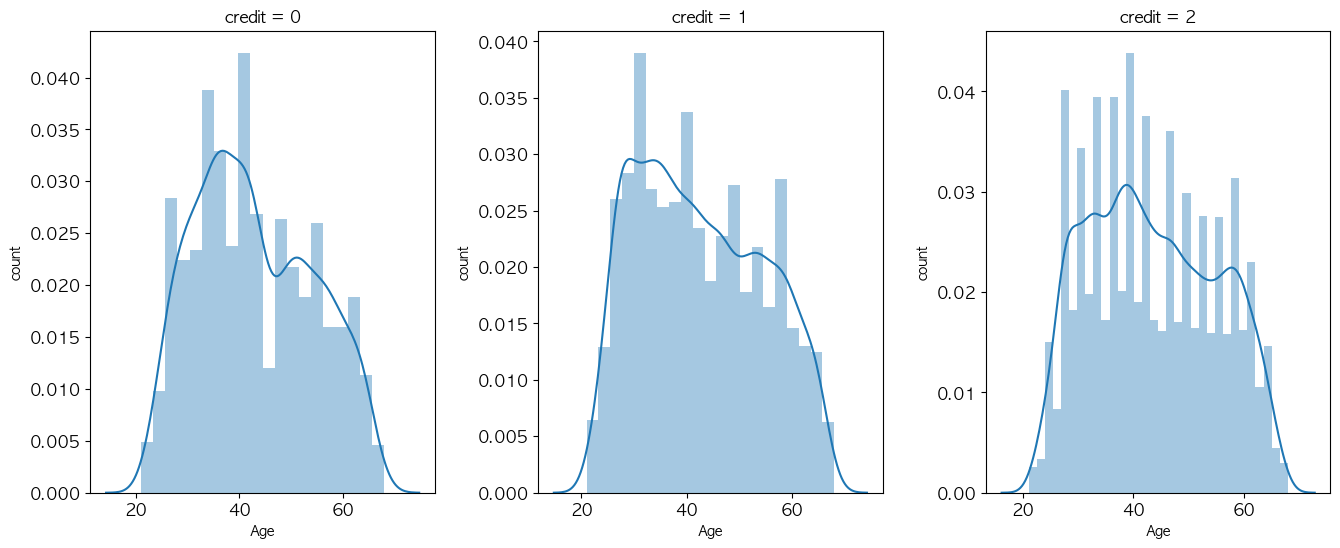

In [21]:
num_plot('Age')

등급별로 큰 차이는 없어 보이지만, **20~30대의 경우 비율이 낮은 것을 알 수 있습니다.**    
그렇다면 나이에 대한 열도 신용등급을 판단하는데 하나의 정보가 될 수 있음을 짐작할 수 있습니다.   
새로운 열 **'Age'** 를 만들어볼까요? 

In [22]:
# 나이 
dt_train['Age'] = train['DAYS_BIRTH']//365
dt_test['Age'] = test['DAYS_BIRTH']//365

display(dt_train)

,emp,BIRTH_MINUS_EMPLOYED,diff_fam_child,INCOME_FAM_RATIO,INCOME_child_num_RATIO,Age
0,1,-9190,2.0,101250.0,0.0,-39
1,1,-9840,2.0,82500.0,247500.0,-32
2,1,-14653,2.0,225000.0,0.0,-53
3,1,-12996,2.0,101250.0,0.0,-42
4,1,-12932,2.0,78750.0,0.0,-42
...,...,...,...,...,...,...
26452,1,-10095,2.0,56250.0,112500.0,-34
26453,1,-12816,1.0,90000.0,180000.0,-42
26454,1,-8067,2.0,146250.0,0.0,-28
26455,1,-10038,1.0,171000.0,0.0,-28


## 1.4 신용등급에 따라 카드 발급 기간 차이가 존재할까?

데이터를 전처리하여 Month 변수를 도출해보겠습니다. 

In [23]:
train_0['Month'] = abs(train_0['begin_month'])
train_1['Month'] = abs(train_1['begin_month'])
train_2['Month'] = abs(train_2['begin_month'])
train_0 = train_0.astype({'Month': 'int'})
train_1 = train_1.astype({'Month': 'int'})
train_2 = train_2.astype({'Month': 'int'})
train_0['Month'].head()

3     37
7     53
12    60
15    60
22    22
Name: Month, dtype: int64

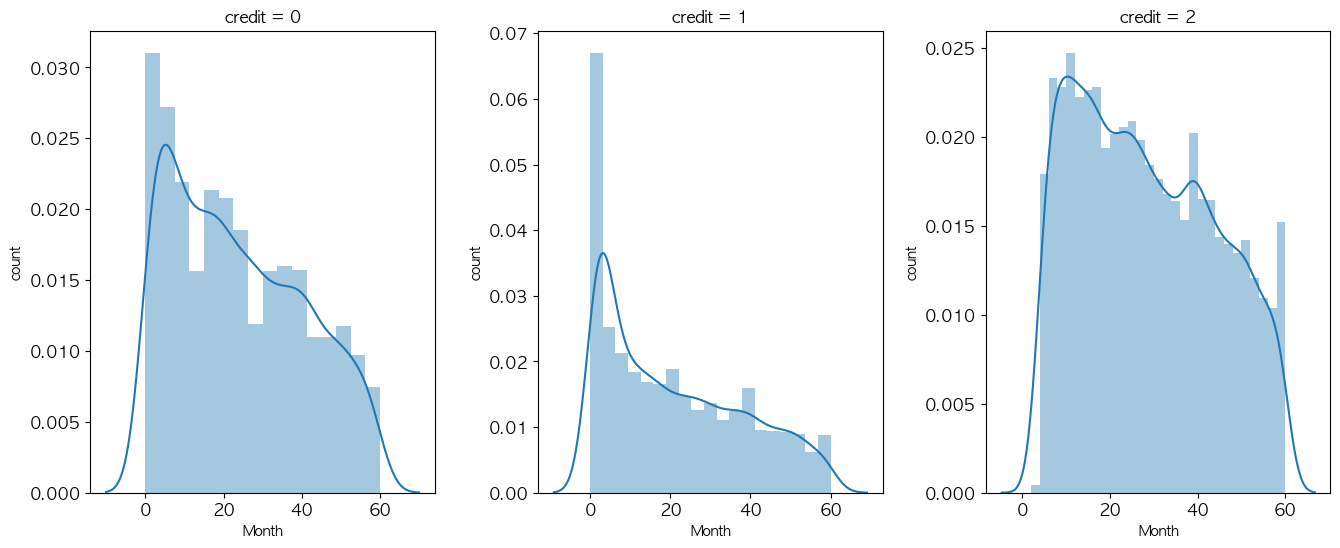

In [24]:
num_plot("Month")

등급에 따라 그래프의 모양이 비슷하지만, 대부분이 카드를 발급한지 10달 이하인 사람이 많다는 것을 알 수 있습니다.   

## 1.5 신용 등급에 따라 업무 기간 차이가 존재할까?

이번에는 업무 기간을 연도 단위로 분석해 볼까요?   
먼저 데이터 전처리를 할때, 양수는 고용되지 않은 상태로 무직을 의미하므로 0으로 대체하도록 하겠습니다. 😉

In [25]:
train_0['EMPLOYED']= train_0['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)
train_1['EMPLOYED']= train_1['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)
train_2['EMPLOYED']= train_2['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)
train_0['EMPLOYED'] = abs(train_0['EMPLOYED'])
train_1['EMPLOYED'] = abs(train_1['EMPLOYED'])
train_2['EMPLOYED'] = abs(train_2['EMPLOYED'])
train_0['EMPLOYED'].head()

3     2092
7     5420
12    2162
15    4056
22    1357
Name: EMPLOYED, dtype: int64

In [26]:
train_0 = train_0.astype({'EMPLOYED': 'int'})
train_1 = train_1.astype({'EMPLOYED': 'int'})
train_2 = train_2.astype({'EMPLOYED': 'int'})

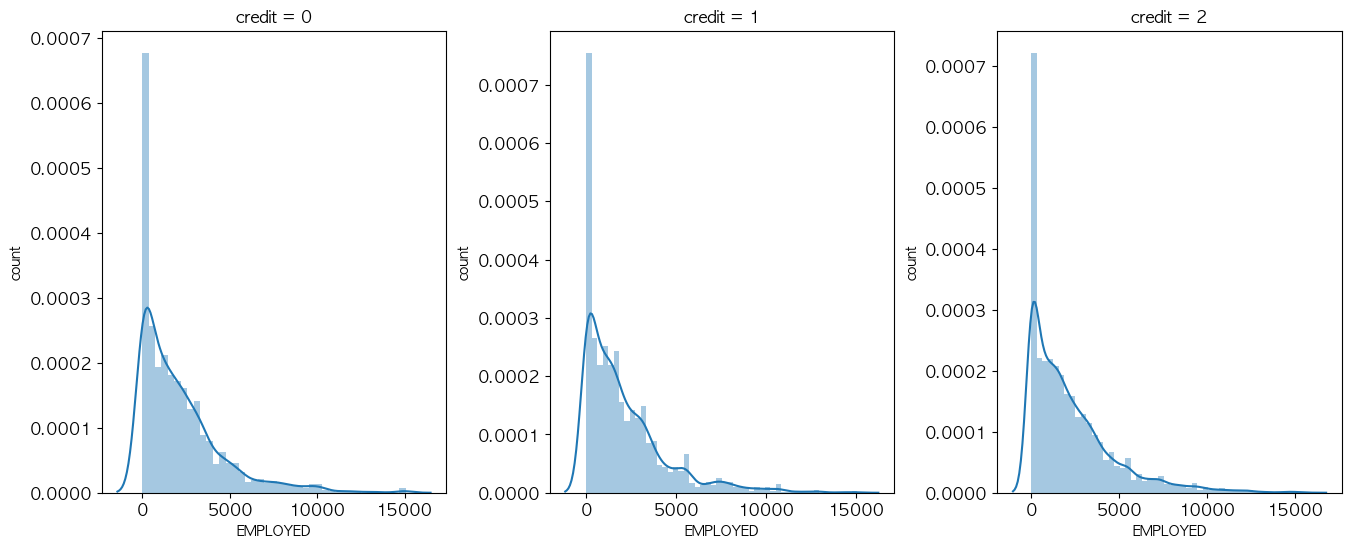

In [27]:
num_plot("EMPLOYED")

이 그래프를 통해 우리는 **대체적으로 직업이 없는 사람이 많다는 것을 알 수 있습니다.** 😳    
그렇다면 사람들마다 무직이였던 상태가 얼마나 지속되었는지를 변수로 만들 수 있을 겁니다.   
같이 한번 해볼까요? 


In [28]:
# 무직이었던 기간 
dt_train['before_EMPLOYED'] = train['DAYS_BIRTH'] - train['DAYS_EMPLOYED']
dt_test['before_EMPLOYED'] = test['DAYS_BIRTH'] - test['DAYS_EMPLOYED']

display(dt_train)

,emp,BIRTH_MINUS_EMPLOYED,diff_fam_child,INCOME_FAM_RATIO,INCOME_child_num_RATIO,Age,before_EMPLOYED
0,1,-9190,2.0,101250.0,0.0,-39,-9190
1,1,-9840,2.0,82500.0,247500.0,-32,-9840
2,1,-14653,2.0,225000.0,0.0,-53,-14653
3,1,-12996,2.0,101250.0,0.0,-42,-12996
4,1,-12932,2.0,78750.0,0.0,-42,-12932
...,...,...,...,...,...,...,...
26452,1,-10095,2.0,56250.0,112500.0,-34,-10095
26453,1,-12816,1.0,90000.0,180000.0,-42,-12816
26454,1,-8067,2.0,146250.0,0.0,-28,-8067
26455,1,-10038,1.0,171000.0,0.0,-28,-10038


무직이었던 기간을 이용해 무직이었을 때의 수입의 비율을 구해볼 수도 있겠죠? 

In [29]:
dt_train['income_total_beforeEMP_RATIO'] = train['income_total'] / dt_train['before_EMPLOYED']
dt_test['income_total_beforeEMP_RATIO'] = test['income_total'] / dt_test['before_EMPLOYED']

display(dt_train)

,emp,BIRTH_MINUS_EMPLOYED,diff_fam_child,INCOME_FAM_RATIO,INCOME_child_num_RATIO,Age,before_EMPLOYED,income_total_beforeEMP_RATIO
0,1,-9190,2.0,101250.0,0.0,-39,-9190,-22.034820
1,1,-9840,2.0,82500.0,247500.0,-32,-9840,-25.152439
2,1,-14653,2.0,225000.0,0.0,-53,-14653,-30.710435
3,1,-12996,2.0,101250.0,0.0,-42,-12996,-15.581717
4,1,-12932,2.0,78750.0,0.0,-42,-12932,-12.179091
...,...,...,...,...,...,...,...,...
26452,1,-10095,2.0,56250.0,112500.0,-34,-10095,-22.288262
26453,1,-12816,1.0,90000.0,180000.0,-42,-12816,-14.044944
26454,1,-8067,2.0,146250.0,0.0,-28,-8067,-36.258832
26455,1,-10038,1.0,171000.0,0.0,-28,-10038,-17.035266


### Inst. 
- 앞서 주어지지 않은 새로운 열을 3개 이상 만들어 보세요! 
- 이미 만들어진 열을 사용해도 좋습니다. 

In [30]:
# 새로운 열 생성 




### Hint. 
- empty

### Solution 

- 몇가지 예시만 들어보겠습니다. 😁
- 참고만 하시고 직접 다양한 열을 시각화 해보고 만들어보세요!! 

In [31]:
# 직장인이었던 기간 (연도기준)
dt_train['EMPLOYED'] = train['DAYS_EMPLOYED'] // 365 
dt_test['EMPLOYED'] = test['DAYS_EMPLOYED'] // 365

# 사람당 수입의 비율 
dt_train['income_per_person'] = train['income_total'] / train['family_size']
dt_test['income_per_person'] = test['income_total'] / test['family_size']


# 편차 제곱 변수 생성 
dt_train['income_total_dev'] = (train['income_total'] - train['income_total'].mean()**2)
dt_test['income_total_dev'] = (test['income_total'] - test['income_total'].mean()**2)

display(dt_train)

,emp,BIRTH_MINUS_EMPLOYED,diff_fam_child,INCOME_FAM_RATIO,INCOME_child_num_RATIO,Age,before_EMPLOYED,income_total_beforeEMP_RATIO,EMPLOYED,income_per_person,income_total_dev
0,1,-9190,2.0,101250.0,0.0,-39,-9190,-22.034820,-13,101250.0,-3.508353e+10
1,1,-9840,2.0,82500.0,247500.0,-32,-9840,-25.152439,-5,82500.0,-3.508349e+10
2,1,-14653,2.0,225000.0,0.0,-53,-14653,-30.710435,-13,225000.0,-3.508328e+10
3,1,-12996,2.0,101250.0,0.0,-42,-12996,-15.581717,-6,101250.0,-3.508353e+10
4,1,-12932,2.0,78750.0,0.0,-42,-12932,-12.179091,-6,78750.0,-3.508358e+10
...,...,...,...,...,...,...,...,...,...,...,...
26452,1,-10095,2.0,56250.0,112500.0,-34,-10095,-22.288262,-6,56250.0,-3.508351e+10
26453,1,-12816,1.0,90000.0,180000.0,-42,-12816,-14.044944,-7,90000.0,-3.508355e+10
26454,1,-8067,2.0,146250.0,0.0,-28,-8067,-36.258832,-6,146250.0,-3.508344e+10
26455,1,-10038,1.0,171000.0,0.0,-28,-10038,-17.035266,-1,171000.0,-3.508356e+10


# 2. 새로운 변수를 더하여 결과 제출해보기 

우리는 앞서 다양한 변수를 시각화를 기반으로 생성해보았습니다.   
그렇다면 우리가 **앞서 전처리한 데이터**에 새로 생성한 dt_train과 dt_test를 concat해야겠죠? 

In [32]:
# 전처리한 데이터 불러오기 
train = pd.read_csv('train_pre.csv')
test = pd.read_csv('test_pre.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [33]:
# 새로운 열 concat 
train = pd.concat([train,dt_train],axis=1)
test = pd.concat([test,dt_test],axis=1)

display(train)
display(test)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,BIRTH_MINUS_EMPLOYED,diff_fam_child,INCOME_FAM_RATIO,INCOME_child_num_RATIO,Age,before_EMPLOYED,income_total_beforeEMP_RATIO,EMPLOYED,income_per_person,income_total_dev
0,0,0,0,0,0,0,0,1,1,2,...,-9190,2.0,101250.0,0.0,-39,-9190,-22.034820,-13,101250.0,-3.508353e+10
1,1,0,0,1,1,0,0,4,0,1,...,-9840,2.0,82500.0,247500.0,-32,-9840,-25.152439,-5,82500.0,-3.508349e+10
2,2,1,1,1,0,1,4,1,1,1,...,-14653,2.0,225000.0,0.0,-53,-14653,-30.710435,-13,225000.0,-3.508328e+10
3,3,0,0,1,0,0,0,4,1,1,...,-12996,2.0,101250.0,0.0,-42,-12996,-15.581717,-6,101250.0,-3.508353e+10
4,4,0,1,1,0,0,2,1,1,1,...,-12932,2.0,78750.0,0.0,-42,-12932,-12.179091,-6,78750.0,-3.508358e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,0,0,0,2,0,2,4,1,1,...,-10095,2.0,56250.0,112500.0,-34,-10095,-22.288262,-6,56250.0,-3.508351e+10
26453,26453,0,0,1,1,0,4,1,2,1,...,-12816,1.0,90000.0,180000.0,-42,-12816,-14.044944,-7,90000.0,-3.508355e+10
26454,26454,0,1,0,0,1,4,4,0,5,...,-8067,2.0,146250.0,0.0,-28,-8067,-36.258832,-6,146250.0,-3.508344e+10
26455,26455,1,0,1,0,0,4,2,3,1,...,-10038,1.0,171000.0,0.0,-28,-10038,-17.035266,-1,171000.0,-3.508356e+10


,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,BIRTH_MINUS_EMPLOYED,diff_fam_child,INCOME_FAM_RATIO,INCOME_child_num_RATIO,Age,before_EMPLOYED,income_total_beforeEMP_RATIO,EMPLOYED,income_per_person,income_total_dev
0,26457,1,1,0,0,0,1,4,0,1,...,-387233,2.0,56250.0,0.0,-61,-387233,-0.290523,1000,56250.0,-3.424092e+10
1,26458,0,0,1,0,0,2,1,1,1,...,-10293,2.0,67500.0,0.0,-52,-10293,-13.115710,-24,67500.0,-3.424089e+10
2,26459,0,0,1,0,0,4,4,1,1,...,-15670,2.0,34686.0,0.0,-44,-15670,-4.427058,-1,34686.0,-3.424096e+10
3,26460,1,1,0,0,0,0,4,1,1,...,-16739,2.0,56250.0,0.0,-53,-16739,-6.720832,-7,56250.0,-3.424092e+10
4,26461,0,1,1,0,0,2,1,1,1,...,-8437,2.0,112500.0,0.0,-49,-8437,-26.668247,-26,112500.0,-3.424080e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,0,1,1,0,0,4,2,1,1,...,-13159,2.0,101250.0,0.0,-51,-13159,-15.388707,-15,101250.0,-3.424083e+10
9996,36453,1,1,1,0,0,4,4,0,1,...,-9571,2.0,101250.0,0.0,-30,-9571,-21.157664,-4,101250.0,-3.424083e+10
9997,36454,0,0,1,0,1,4,4,1,1,...,-6998,2.0,146250.0,0.0,-58,-6998,-41.797656,-39,146250.0,-3.424074e+10
9998,36455,0,1,0,0,0,0,4,1,1,...,-15456,2.0,90000.0,0.0,-46,-15456,-11.645963,-3,90000.0,-3.424085e+10


In [34]:
# data, target 만들기

data = train.drop(['credit'],axis=1)
target = train['credit']

In [35]:
# train, validation 만들기

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(data, target, test_size=0.3)

In [36]:
# RandomForestClassifier Import
from sklearn.ensemble import RandomForestClassifier

# Train
rf_model = RandomForestClassifier() # 모델 지정
rf_model.fit(x_train,y_train) # 모델 학습

RandomForestClassifier()

In [37]:
# evaluation

from sklearn.metrics import accuracy_score, log_loss

val_pred = rf_model.predict(x_valid) # validation 예측
print('accuracy_score : ' ,accuracy_score(y_valid,val_pred))

val_pred2 = rf_model.predict_proba(x_valid) # validation 확률 예측
print('log_loss : ' ,log_loss(y_valid,val_pred2))

accuracy_score :  0.6586041824137062
log_loss :  0.9305948411690971


In [38]:
# Predict

test_pred = rf_model.predict_proba(test) # test 예측
submission.iloc[:,1:] = test_pred # DataFrame 생성
submission

,index,0,1,2
0,26457,0.21,0.33,0.46
1,26458,0.24,0.30,0.46
2,26459,0.24,0.16,0.60
3,26460,0.19,0.27,0.54
4,26461,0.14,0.50,0.36
...,...,...,...,...
9995,36452,0.13,0.34,0.53
9996,36453,0.20,0.36,0.44
9997,36454,0.09,0.23,0.68
9998,36455,0.35,0.25,0.40


### Inst.
- 여태까지 생성한 새로운 feature를 기존 전처리한 파일에 concat하여 내보내세요. 
- 파일명은 train_f, test_f로 지정해주세요. 

In [39]:
# 파일 내보내기 

train.to_csv('train_f.csv',index=False)
test.to_csv('test_f.csv',index=False)

### Hint.
- empty

### Solution 
- 이 solution은 해당 stage에서 생성한 피처만을 포함하고 있습니다. 
- 여러분이 생성한 피처를 concat 하여 새롭게 완성해주세요! 😊

In [40]:
# 파일 내보내기 


# Outro

새로운 열을 추가해서 RandomForest 모델을 사용해본 결과 Stage4보다 성능이 소폭 상승한 것을 확인할 수 있습니다.   

오늘 저와 함께 생성한 열 이외에도 새로운 열은 무궁무진하게 만들 수 있습니다.   
더더더 많은 열을 생성해 모델 성능을 높여보세요! 😉  

다음 시간은 벌써 마지막 시간입니다. 😭  
다음에는 **좀 더 무거운 모델을 사용해 성능을 높이고 좀 더 고급 데이터 분석 기술을 다뤄보도록 하겠습니다.**     
다음 Stage에서 만나요!! ✌️